In [101]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import confusion_matrix

In [66]:
cur_file = Path(os.getcwd())
working_dir = cur_file.parent
parent_dir = working_dir.parent
data_dir = parent_dir.joinpath('data')

In [67]:
org_dir = data_dir.joinpath('processed/preprocess_1')
syn_dir = data_dir.joinpath('processed/decoded')

In [68]:
train = pd.read_pickle(org_dir.joinpath('train_ori_50.pkl'))
test = pd.read_pickle(org_dir.joinpath('test_50.pkl'))
syn = pd.read_csv(syn_dir.joinpath('Synthetic_data_epsilon10000_50.csv'),index_col = 0)
#syn = pd.read_csv('/home/dogu86/2022_DATA_SYNTHESIS/young_age/Synthetic_data_epsilon0_50.csv',index_col=0)
#syn = pd.read_csv('/home/dogu86/young_age_colon_cancer/final_data/synthetic_decoded/Synthetic_data_epsilon10000.csv')
syn.rename(columns = {'RLPS_DIFF' : 'RLPS DIFF'}, inplace = True)
syn = syn.drop('OVR_SURV',axis=1)
train=train.drop('OVR_SURV',axis=1)

In [69]:
dead_test = test[test['DEAD']==1]
alive_test = test[test['DEAD']==0].sample(len(dead_test)*5)

test = pd.concat([dead_test,alive_test],axis=0)

In [70]:
test_x = test.drop(['DEAD','DEAD_DIFF','PT_SBST_NO','OVR_SURV'], axis=1)
test_x = test_x.replace(np.NaN,999)

In [71]:
def get_feature_importances(model,feature):
    import seaborn as sns
    import matplotlib.pyplot as plt

    importances = model.feature_importances_
    #feature = x.columns
    imp, feat = (list(x) for x in zip(*sorted(zip(importances, feature), reverse=True)))

    plt.figure(figsize=(13, 10))
    sns.barplot(imp[:30], feat[:30])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Classification Feature Importances (Top 30)', fontsize=18)
    plt.show()

In [72]:
def get_best_model(data,valid,model_name):

    if model_name in ['dt','rf']:
        grid_parameters = {"max_depth": [2,4,5,7,9,10,50],
                       "min_samples_split": [2,3,4]}
        return tree_like(model_name,data,valid,grid_parameters)
        
    elif model_name == 'xgb':
        grid_parameters = {"max_depth": [4,5,7,10,50], 
                           'learning_rate':[0.01, 0.1]}
        return get_xgb(model_name,data,valid,grid_parameters)
    
    elif model_name == 'mlp':
        grid_parameters = {"hidden_layer_size": [[10,10,10],[50,50,50],[70,70,70],[100,100,100]], 
                           'learning_rate_int':[0.01, 0.1]}
        return get_mlp(model_name,data,valid,grid_parameters)    
    elif model_name == 'knn':
        grid_parameters = {"n_neighbors" : [2,3,4,5]}
        return get_knn(model_name,data,valid,grid_parameters)
        
    else:
        print('model name error')
        return 0

In [73]:
def get_simple_model(data,valid,model):

    x, y, valid_x, valid_y = get_data(data,valid)

    scores = []
    models = []
    
    scaler = StandardScaler()
    
    x = scaler.fit_transform(x)
    valid_x = scaler.fit_transform(valid_x)
    
    train_model = model.fit(x,y)
    
    return model

In [74]:
def tree_like(model_name,data,valid,param):
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=0) # KFold 객체 생성
    
    x, y, valid_x, valid_y = get_data(data,valid)

    scores = []
    models = []
    
    scaler = StandardScaler()
    
    x = scaler.fit_transform(x)
    valid_x = scaler.fit_transform(valid_x)
    
    for i in range(len(param['max_depth'])):
        for k in range(len(param['min_samples_split'])):
            if model_name == 'dt':
                model = DecisionTreeClassifier(max_depth = param['max_depth'][i], 
                                               min_samples_split=param['min_samples_split'][k],
                                              random_state=0)
            elif model_name == 'rf':
                model = RandomForestClassifier(max_depth = param['max_depth'][i], 
                                               min_samples_split=param['min_samples_split'][k],n_jobs=-1,
                                              random_state=0)

            
            model.fit(x,y)
            
            pred = model.predict(valid_x)
            cur_score = roc_auc_score(valid_y,pred)
            #cur_score = cross_val_score(model,valid_x,valid_y,scoring='roc_auc',cv=kfold,n_jobs=-1).mean()
            
            scores.append(cur_score)
            models.append(model)
    
    best_idx = scores.index(max(scores))
    
    print(max(scores), models[best_idx])
    
    return models[best_idx]


In [75]:
def get_xgb(model_name,data,valid,param):
    x, y, valid_x, valid_y = get_data(data,valid)
    
    scores = []
    models = []    
    evals = [(valid_x, valid_y)]
    
    
    for i in range(len(param['max_depth'])):
        for k in range(len(param['learning_rate'])):
            model = XGBClassifier(n_estimators=100, early_stoping_rounds=50,eval_set=evals,
                learning_rate=param['learning_rate'][k], 
                                        max_depth=param['max_depth'][i],objective='binary:logistic',n_jobs=-1)

            model.fit(x, y,verbose=False,early_stopping_rounds=50, 
                        eval_metric='logloss',eval_set=evals)

            cur_score = cross_val_score(model,valid_x,valid_y,scoring='f1_macro',cv=5,n_jobs=-1).mean()

            scores.append(cur_score)
            models.append(model)   
                
    best_idx = scores.index(max(scores))
    
    print(max(scores), models[best_idx])
    
    return models[best_idx]

In [76]:
def get_mlp(model_name,data,valid,param):
    
    x, y, valid_x, valid_y = get_data(data,valid)
    
    scores = []
    models = []   
    scaler = StandardScaler()
    
    x = scaler.fit_transform(x)
    valid_x = scaler.fit_transform(valid_x)
    

    for i in range(len(param['hidden_layer_size'])):
        for k in range(len(param['learning_rate_int'])):
            model = MLPClassifier(activation='logistic',solver='adam',learning_rate='constant',
                learning_rate_init=param['learning_rate_int'][k], 
                                        hidden_layer_sizes=param['hidden_layer_size'][i])

            model.fit(x, y)

            cur_score = cross_val_score(model,valid_x,valid_y,scoring='f1_macro',cv=5,n_jobs=-1).mean()

            scores.append(cur_score)
            models.append(model)   
                
    best_idx = scores.index(max(scores))
    
    print(max(scores), models[best_idx])
    
    return models[best_idx]

In [77]:
def get_knn(model_name,data,valid,param):
    x, y, valid_x, valid_y = get_data(data,valid)    
    
    scores = []
    models = []
    
    scaler = StandardScaler()
    
    x = scaler.fit_transform(x)
    valid_x = scaler.fit_transform(valid_x)    
    for i in (param['n_neighbors']):
        model = KNeighborsClassifier(n_neighbors=i)

        model.fit(x, y)
        pred = model.predict(valid_x)
        cur_score = roc_auc_score(valid_y,pred)
        #cur_score = cross_val_score(model,valid_x,valid_y,scoring='roc_auc',cv=5,n_jobs=-1).mean()

        scores.append(cur_score)
        models.append(model)   
                
    best_idx = scores.index(max(scores))
    
    print(max(scores), models[best_idx])
    
    return models[best_idx]

In [78]:
def get_data(data,test):
    data = data.drop(['PT_SBST_NO'],axis=1)
    data = data.astype(float)


    x = data.drop(['DEAD','DEAD_DIFF'], axis=1)
    x = x.replace(np.NaN,999)
    y = data['DEAD']
    
    
    test_x = test.drop(['DEAD','DEAD_DIFF','PT_SBST_NO'], axis=1)
    test_x = test_x.replace(np.NaN,999)
    test_y = test['DEAD']
    
    
    return [x,y,test_x,test_y]

In [104]:
train_x = train.drop('DEAD',axis=1)
train_y = train['DEAD']

In [105]:
syn_dead = syn[syn['DEAD']==1]
syn_alive = syn[syn['DEAD']==0].sample(len(syn_dead)*2, random_state=0)

syn = pd.concat([syn_dead,syn_alive])

In [106]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.2, stratify=train_y,
                                                   random_state=0)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.2, stratify=train_y,
                                                   random_state=0)
real_valid = pd.concat([X_test,y_test],axis=1)
real_train = pd.concat([X_train,y_train],axis=1)

In [83]:
real_valid

,PT_SBST_NO,BSPT_SEX_CD,BSPT_IDGN_AGE,BSPT_FRST_DIAG_NM,BSPT_STAG_CLSF_CD,BSPT_STAG_VL,RLPS,RLPS DIFF,DEAD_DIFF,BPTH_SITE_CONT,...,REGN_TIME_DIFF_7,REGN_START_DIFF_7,REGN_CSTR_CYCL_VL_END_7,REGN_CSTR_REGN_NM_8,REGN_CSTR_PRPS_NT_8,REGN_CASB_CSTR_PRPS_NM_8,REGN_TIME_DIFF_8,REGN_START_DIFF_8,REGN_CSTR_CYCL_VL_END_8,DEAD
1325,1066,1,41,2,0,4.0,0,NaN,NaN,28,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,0
180,586,0,24,0,0,4.0,0,NaN,249.0,5,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,1
146,623,1,39,0,1,3.0,0,NaN,NaN,5,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,0
280,408,1,35,0,1,3.0,0,NaN,NaN,28,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,0
1172,963,0,29,0,1,1.0,0,NaN,NaN,5,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,622,0,47,2,1,3.0,0,NaN,NaN,20,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,0
552,830,1,42,2,1,1.0,0,NaN,NaN,28,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,0
917,1133,0,24,2,1,1.0,0,NaN,NaN,26,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,0
1231,358,0,47,0,1,2.0,0,NaN,NaN,28,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,0


In [108]:


'''real_dead = train[train['DEAD']==1]
real_alive = train.sample((len(real_dead)))
real_valid = pd.concat([real_dead,real_alive])
real_train = train.drop(real_valid.index)'''

# Get Train Syn - Valid Real
dt_model = get_best_model(syn,real_valid,'dt')
rf_model = get_best_model(syn,real_valid,'rf')
xgb_model = get_best_model(syn,real_valid,'knn')
#mlp_model = get_best_model(syn,real_valid,'mlp')
tstr_models = [dt_model,rf_model,xgb_model]
#tstr_models = [dt_model,rf_model,mlp_model]

# Get Train Real - Valid Real
dt_model_real = get_best_model(real_train,real_valid,'dt')
rf_model_real = get_best_model(real_train,real_valid,'rf')
xgb_model_real = get_best_model(real_train,real_valid,'knn')
#mlp_model_real = get_best_model(real_train,real_valid,'mlp')
trtr_models = [dt_model_real,rf_model_real,xgb_model_real]
#trtr_models = [dt_model_real,rf_model_real,mlp_model_real]
               

0.8913978494623657 DecisionTreeClassifier(max_depth=2, random_state=0)
0.9731182795698925 RandomForestClassifier(max_depth=50, n_jobs=-1, random_state=0)
0.9731182795698925 KNeighborsClassifier(n_neighbors=2)
0.678494623655914 DecisionTreeClassifier(max_depth=5, random_state=0)
0.625268817204301 RandomForestClassifier(max_depth=9, min_samples_split=4, n_jobs=-1,
                       random_state=0)
0.6838709677419355 KNeighborsClassifier(n_neighbors=3)


In [186]:
dt_model_real = get_best_model(real_train,real_valid,'dt')
rf_model_real = get_best_model(real_train,real_valid,'rf')

0.6161191749427044 DecisionTreeClassifier(max_depth=4, random_state=0)
0.700240908569462 RandomForestClassifier(max_depth=4, n_jobs=-1, random_state=0)


In [187]:
dt_model = get_best_model(syn,real_valid,'dt')
rf_model = get_best_model(syn,real_valid,'rf')

0.7312834224598931 DecisionTreeClassifier(max_depth=4, random_state=0)
0.9814181381159286 RandomForestClassifier(max_depth=50, n_jobs=-1, random_state=0)


In [178]:
print(len(real_train),len(syn))

801 5010


/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


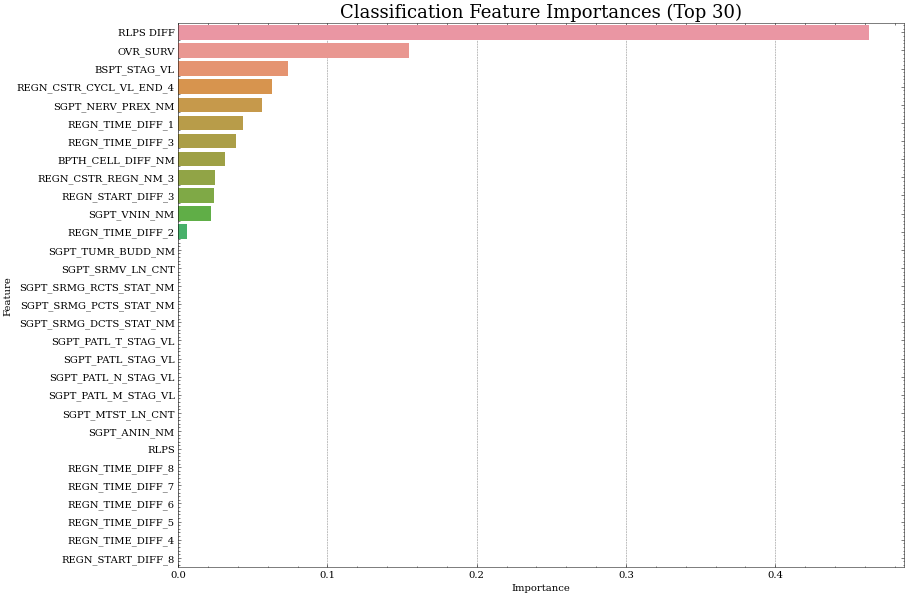

In [184]:
get_feature_importances(dt_model_real, feature=test_x.columns)

/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


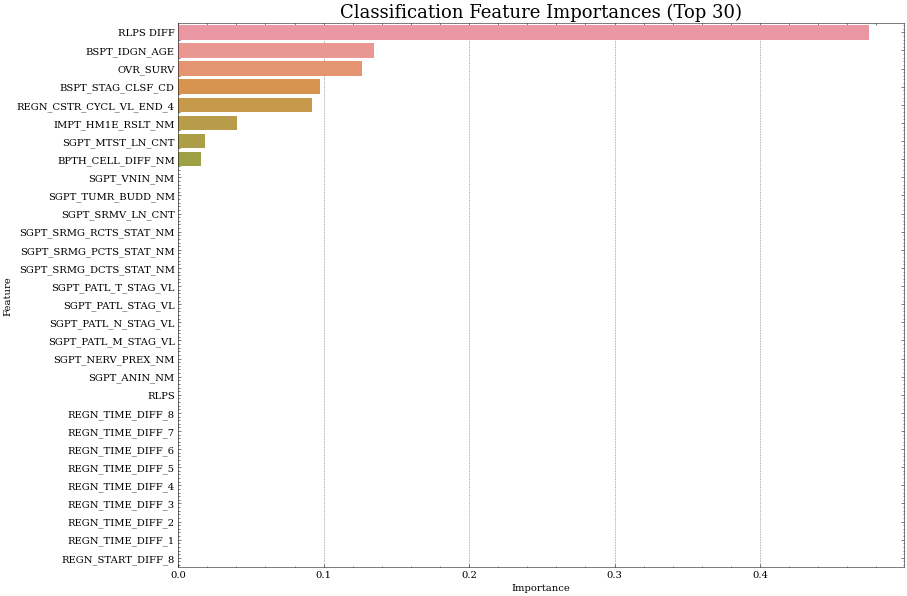

In [185]:
get_feature_importances(dt_model, feature=test_x.columns)

In [49]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


pred = xgb_model_real.predict(test_x)
f1 = f1_score(test['DEAD'],pred,average='macro')
f1

0.7306866952789699

/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [189]:
pred = dt_model.predict(test_x)
f1 = f1_score(test['DEAD'],pred,average='macro')
f1

0.7306866952789699

In [109]:
X_train, X_test, y_train, y_test = train_test_split(syn.drop('DEAD',axis=1), syn['DEAD'], test_size = 0.2, stratify=syn['DEAD'])
syn_valid = pd.concat([X_test,y_test],axis=1)
syn_train = pd.concat([X_train,y_train],axis=1)

# Get Train Syn - Valid Syn
dt_model_tsts = get_best_model(syn_train,syn_valid,'dt')
rf_model_tsts = get_best_model(syn_train,syn_valid,'rf')
xgb_model_tsts = get_best_model(syn_train,syn_valid,'knn')
#mlp_model_tsts = get_best_model(syn_train,syn_valid,'mlp')
tsts_models = [dt_model_tsts,rf_model_tsts,xgb_model_tsts]
#tsts_models = [dt_model_tsts,rf_model_tsts,mlp_model_tsts]

# Get Train Real - Valid Syn
dt_model_trts = get_best_model(real_train,syn_valid,'dt')
rf_model_trts = get_best_model(real_train,syn_valid,'rf')
xgb_model_trts = get_best_model(real_train,syn_valid,'knn')
#mlp_model_trts = get_best_model(real_train,syn_valid,'mlp')
trts_models = [dt_model_trts,rf_model_trts,xgb_model_trts]
#trts_models = [dt_model_trts,rf_model_trts,mlp_model_trts]

0.8486842105263157 DecisionTreeClassifier(max_depth=9, random_state=0)
0.9736842105263158 RandomForestClassifier(max_depth=10, min_samples_split=4, n_jobs=-1,
                       random_state=0)
0.9177631578947368 KNeighborsClassifier(n_neighbors=4)
0.6907894736842106 DecisionTreeClassifier(max_depth=7, random_state=0)
0.506578947368421 RandomForestClassifier(max_depth=7, min_samples_split=3, n_jobs=-1,
                       random_state=0)
0.5361842105263158 KNeighborsClassifier(n_neighbors=3)


In [199]:
#모델 저장

save_dir = cur_file.joinpath('ml_models')

with open(save_dir.joinpath('trts_models.pkl'), 'wb') as f:
    pickle.dump(trts_models, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(save_dir.joinpath('tstr_models.pkl'), 'wb') as f:
    pickle.dump(trts_models, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(save_dir.joinpath('tsts_models.pkl'), 'wb') as f:
    pickle.dump(trts_models, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(save_dir.joinpath('trtr_models.pkl'), 'wb') as f:
    pickle.dump(trtr_models, f, protocol=pickle.HIGHEST_PROTOCOL)
    


In [12]:
# load
save_dir = cur_file.joinpath('ml_models')
with open(save_dir.joinpath('trts_models.pkl'), 'rb') as f:
    trts_models = pickle.load(f)
with open(save_dir.joinpath('tstr_models.pkl'), 'rb') as f:
    tstr_models = pickle.load(f)
with open(save_dir.joinpath('tsts_models.pkl'), 'rb') as f:
    tsts_models = pickle.load(f)
with open(save_dir.joinpath('trtr_models.pkl'), 'rb') as f:
    trtr_models = pickle.load(f)



In [112]:
model_arr = [trtr_models,tstr_models,trts_models,tsts_models]
score_by_case = []
for models in model_arr:
    scores = []
    for model in models:
        f1 = cross_val_score(model,test_x,test['DEAD'],scoring='roc_auc',cv=5,n_jobs=-1)
        scores.append(f1.mean())
    score_by_case.append(scores)

In [116]:
score_by_case = []
model_arr = [trtr_models,tstr_models,trts_models,tsts_models]
from sklearn.metrics import f1_score
for models in model_arr:
    scores = []
    for model in models:
        pred = model.predict(test_x)
        f1 = roc_auc_score(test['DEAD'],pred)
        print(confusion_matrix(test['DEAD'],pred))
        scores.append(f1)
    score_by_case.append(scores)

/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/h

[[95  0]
 [19  0]]
[[95  0]
 [19  0]]
[[94  1]
 [14  5]]
[[ 4 91]
 [ 1 18]]
[[95  0]
 [19  0]]
[[ 3 92]
 [ 8 11]]
[[95  0]
 [19  0]]
[[95  0]
 [19  0]]
[[94  1]
 [14  5]]
[[ 0 95]
 [ 0 19]]
[[95  0]
 [19  0]]
[[ 0 95]
 [ 3 16]]


/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/h

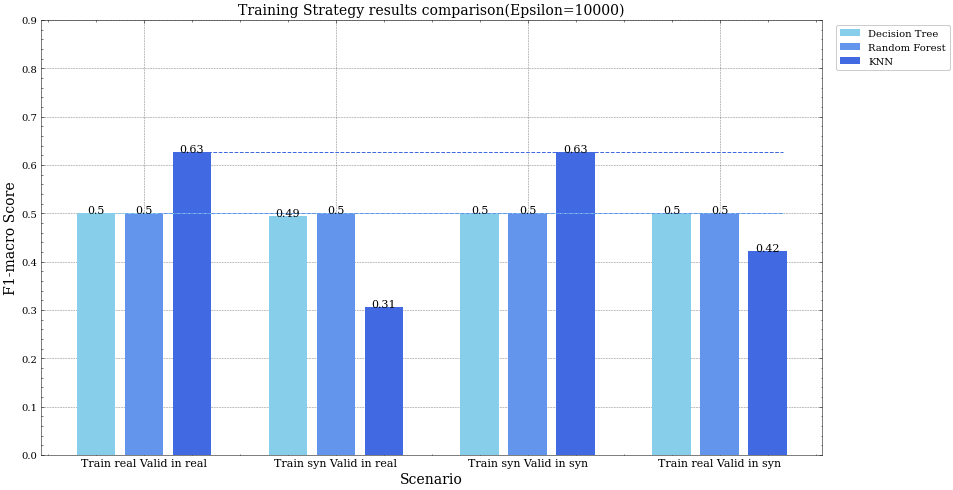

In [117]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','grid','no-latex','vibrant'])
plt.figure(figsize=(14,8))

X1=[1,3,5,7]
data1 = np.array(score_by_case).transpose()[0]
plt.bar(X1, data1,width=0.4,label='Decision Tree', color='skyblue')
plt.axhline(np.array(score_by_case).transpose()[0][0], 0.05, 0.95, linestyle='--',color='skyblue', linewidth=1)
for i, v in enumerate(data1):
    plt.text(X1[i], v, str(round(v,2)), ha='center', fontsize=11)


X2=[1+0.5,3+0.5,5+0.5,7+0.5]
data2 = np.array(score_by_case).transpose()[1]
plt.bar(X2, data2,width=0.4,label='Random Forest',color = 'cornflowerblue')
plt.axhline(np.array(score_by_case).transpose()[1][0], 0.15, 0.95, color = 'cornflowerblue' ,linestyle='--', linewidth=1)
for i, v in enumerate(data2):
    plt.text(X2[i], v, str(round(v,3)), ha='center', fontsize=11)


X3=[1+1,3+1,5+1,7+1]
data3 = np.array(score_by_case).transpose()[2]
plt.bar(X3, data3,width=0.4,label='KNN',color = 'royalblue')
plt.axhline(np.array(score_by_case).transpose()[2][0], 0.2, 0.95, color = 'royalblue',  linestyle='--', linewidth=1)
for i, v in enumerate(data3):
    plt.text(X3[i], v, str(round(v,2)), ha='center', fontsize=11)



plt.legend(loc='upper right',bbox_to_anchor=(1.17, 1))
ticklabel=['Train real Valid in real','Train syn Valid in real','Train syn Valid in syn','Train real Valid in syn']
plt.xticks(X2,ticklabel, fontsize=11)

plt.xlabel('Scenario',fontsize=14)
plt.ylabel('F1-macro Score',fontsize=14)

plt.yticks(np.arange(0,1,0.1))

plt.title('Training Strategy results comparison(Epsilon=10000)', fontsize=14)

plt.show()

/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


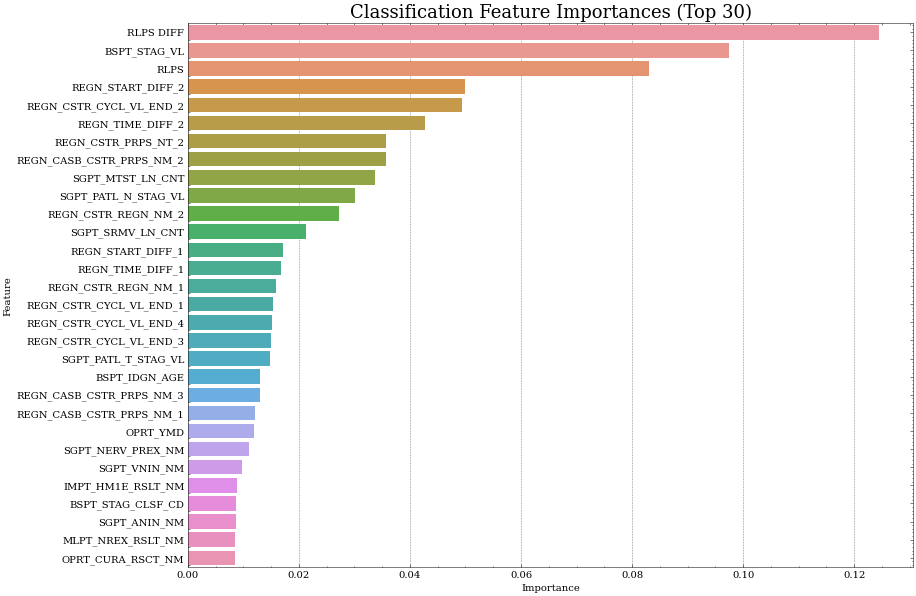

In [118]:
#trtr
get_feature_importances(tsts_models[1],feature=test_x.columns)


/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


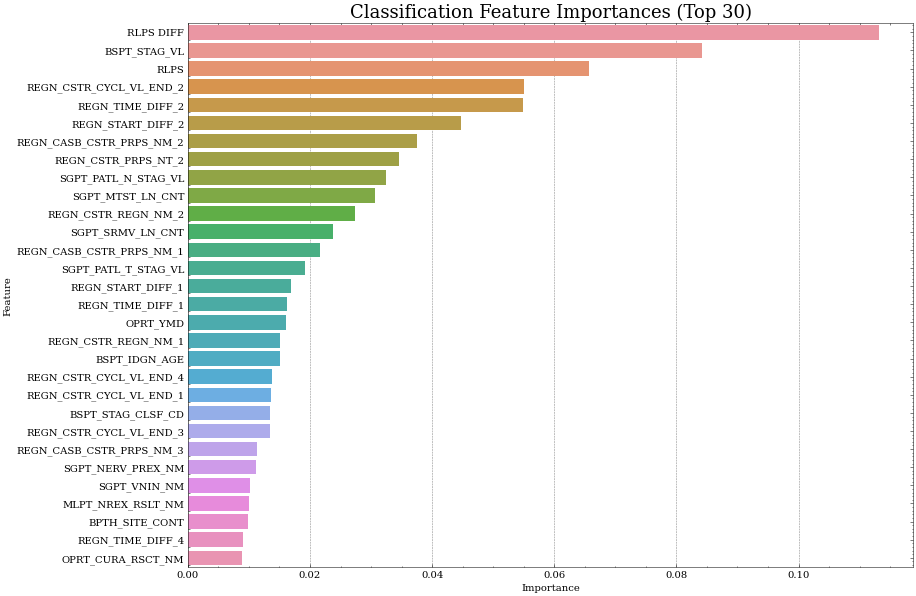

In [119]:
#tstr
get_feature_importances(model_arr[1][1],feature=test_x.columns)

In [28]:
syn['DEAD'].value_counts()

0    2918
1    2092
Name: DEAD, dtype: int64

[10:54:48] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:48] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:48] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:49] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46]

In [38]:
syn['RLPS'].value_counts()

0    2955
1    2055
Name: RLPS, dtype: int64

In [36]:
train['RLPS'].value_counts()

0    853
1    149
Name: RLPS, dtype: int64

In [32]:
syn.columns

Index(['Unnamed: 0', 'PT_SBST_NO', 'BSPT_SEX_CD', 'BSPT_IDGN_AGE',
       'BSPT_FRST_DIAG_NM', 'BSPT_STAG_CLSF_CD', 'BSPT_STAG_VL', 'RLPS',
       'RLPS DIFF', 'DEAD', 'DEAD_DIFF', 'OVR_SURV', 'BPTH_SITE_CONT',
       'BPTH_CELL_DIFF_NM', 'OPRT_YMD', 'OPRT_CLCN_OPRT_KIND_NM',
       'OPRT_CURA_RSCT_NM', 'SGPT_PATL_STAG_VL', 'SGPT_PATL_T_STAG_VL',
       'SGPT_PATL_N_STAG_VL', 'SGPT_PATL_M_STAG_VL', 'SGPT_SRMV_LN_CNT',
       'SGPT_MTST_LN_CNT', 'SGPT_SRMG_PCTS_STAT_NM', 'SGPT_SRMG_DCTS_STAT_NM',
       'SGPT_SRMG_RCTS_STAT_NM', 'SGPT_NERV_PREX_NM', 'SGPT_VNIN_NM',
       'SGPT_ANIN_NM', 'SGPT_TUMR_BUDD_NM', 'MLPT_MSIE_RSLT_NM',
       'MLPT_KE2E_RSLT_NM', 'MLPT_KRES_RSLT_NM', 'MLPT_NREX_RSLT_NM',
       'MLPT_BRME_RSLT_NM', 'IMPT_HM1E_RSLT_NM', 'IMPT_HS2E_RSLT_NM',
       'IMPT_HS6E_RSLT_NM', 'REGN_IMPT_HP2E_RSLT_NM', 'REGN_CSTR_REGN_NM_1',
       'REGN_CSTR_PRPS_NT_1', 'REGN_CASB_CSTR_PRPS_NM_1', 'REGN_TIME_DIFF_1',
       'REGN_START_DIFF_1', 'REGN_CSTR_CYCL_VL_END_1', 'REGN_CSTR_REG

In [42]:
import os
print(os.environ['PATH'])

/opt/apache-maven-3.6.3/bin:/home/dogu86/.vscode-server/bin/e2816fe719a4026ffa1ee0189dc89bdfdbafb164/bin/remote-cli:/opt/rh/devtoolset-9/root/usr/bin:/opt/apache-maven-3.6.3/bin:/opt/rh/devtoolset-9/root/usr/bin:/opt/apache-maven-3.6.3/bin:/usr/condabin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/usr/local/jvm/jdk1.8.0_241/bin:/usr/local/tesseract-5.0/bin:/home/dogu86/.local/bin:/home/dogu86/bin:/usr/local/jvm/jdk1.8.0_241/bin:/usr/local/tesseract-5.0/bin:/home/dogu86/.local/bin:/home/dogu86/bin


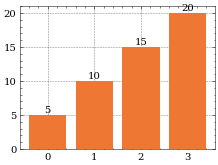

In [110]:
import matplotlib.pyplot as plt

# Create sample data
data = [5, 10, 15, 20]

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(range(len(data)), data)

# Add the numeric information to the plot
for i, v in enumerate(data):
    ax.text(i, v + 0.5, str(v), ha='center')

# Show the plot
plt.show()

In [44]:
def return_roc_score(model,test_x,test_y,pred):
    pred = model.predict(test_x)
    score = accuracy_score(test_y,pred)
    
    return score

In [45]:
dt_score = []
rf_score = []
knn_score = []
mlp_score = []
real_score = []


X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.25, stratify=train_y)
real_valid = pd.concat([X_test,y_test],axis=1)
real_train = pd.concat([X_train,y_train],axis=1)

dt_model_trtr = get_best_model(real_train,real_valid,'dt')
rf_model_trtr = get_best_model(real_train,real_valid,'rf')
knn_model_trtr = get_best_model(real_train,real_valid,'knn')

pred = dt_model_trtr.predict(test_x)
real_score.append(return_roc_score(dt_model_trtr,test_x,test['DEAD'],pred))

pred = rf_model_trtr.predict(test_x)
real_score.append(return_roc_score(rf_model_trtr,test_x,test['DEAD'],pred))

pred = knn_model_trtr.predict(test_x)
real_score.append(return_roc_score(knn_model_trtr,test_x,test['DEAD'],pred))

0.651429219600726 DecisionTreeClassifier(max_depth=4, random_state=0)
0.6272686025408348 RandomForestClassifier(max_depth=50, n_jobs=-1, random_state=0)
0.7325317604355717 KNeighborsClassifier(n_neighbors=3)


/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/h

In [51]:
pred = dt_model_trtr.predict(test_x)
real_score.append(return_roc_score(rf_model_trtr,test_x,test['DEAD'],pred))
pred

/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [48]:
list(test['DEAD'])

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [217]:
path = '/home/dogu86/2022_DATA_SYNTHESIS/young_age/data/processed/2_produce_data/synthetic_decoded/synthetic_data'
for epsilon in [0.1, 1,10,100,1000,10000,0]:
    syn = pd.read_csv(path+f'/Synthetic_data_epsilon{epsilon}_50.csv')
    syn = syn.drop(['Unnamed: 0','OVR_SURV'],axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(syn.drop('DEAD',axis=1), syn['DEAD'], test_size = 0.25, stratify=syn['DEAD'])
    syn_valid = pd.concat([X_test,y_test],axis=1)
    syn_train = pd.concat([X_train,y_train],axis=1)
    
    dt_model_tsts = get_best_model(syn_train,syn_valid,'dt')
    rf_model_tsts = get_best_model(syn_train,syn_valid,'rf')
    knn_model_tsts = get_best_model(syn_train,syn_valid,'knn')
    
    pred = dt_model_tsts.predict(test_x)
    dt_score.append(return_roc_score(dt_model_tsts,test_x,test['DEAD'],pred))

    pred = rf_model_tsts.predict(test_x)
    rf_score.append(return_roc_score(rf_model_tsts,test_x,test['DEAD'],pred))

    pred = knn_model_tsts.predict(test_x)
    knn_score.append(return_roc_score(knn_model_tsts,test_x,test['DEAD'],pred))

0.7066696914700544 DecisionTreeClassifier(max_depth=9, min_samples_split=4, random_state=0)
0.6777450090744102 RandomForestClassifier(max_depth=7, min_samples_split=3, n_jobs=-1,
                       random_state=0)
0.743761343012704 KNeighborsClassifier(n_neighbors=3)
0.9576172496929446 DecisionTreeClassifier(max_depth=7, random_state=0)
0.883778374198244 RandomForestClassifier(max_depth=50, n_jobs=-1, random_state=0)
0.8922212618841833 KNeighborsClassifier(n_neighbors=3)
0.9269799390438065 DecisionTreeClassifier(max_depth=9, min_samples_split=4, random_state=0)
0.9258836373561388 RandomForestClassifier(max_depth=10, min_samples_split=4, n_jobs=-1,
                       random_state=0)
0.9391575308192696 KNeighborsClassifier(n_neighbors=3)
0.837428922349088 DecisionTreeClassifier(max_depth=50, random_state=0)
0.8153573215666652 RandomForestClassifier(max_depth=50, min_samples_split=3, n_jobs=-1,
                       random_state=0)
0.8698721739525997 KNeighborsClassifier(n_neighb

In [170]:
dt_score = []
rf_score = []
knn_score = []
mlp_score = []
real_score = []


X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.4, stratify=train_y)
real_valid = pd.concat([X_test,y_test],axis=1)
real_train = pd.concat([X_train,y_train],axis=1)

dt_model_trtr = get_simple_model(real_train,real_valid,DecisionTreeClassifier(max_depth=20))
rf_model_trtr = get_simple_model(real_train,real_valid,RandomForestClassifier(max_depth=20))
knn_model_trtr = get_simple_model(real_train,real_valid,KNeighborsClassifier())

pred = dt_model_trtr.predict(test_x)
real_score.append(return_roc_score(dt_model_trtr,test_x,test['DEAD'],pred))

pred = rf_model_trtr.predict(test_x)
real_score.append(return_roc_score(rf_model_trtr,test_x,test['DEAD'],pred))

pred = knn_model_trtr.predict(test_x)
real_score.append(return_roc_score(knn_model_trtr,test_x,test['DEAD'],pred))


path = '/home/dogu86/2022_DATA_SYNTHESIS/young_age/data/processed/2_produce_data/synthetic_decoded/synthetic_data'
for epsilon in [0.1, 1,10,100,1000,10000,0]:
    syn = pd.read_csv(path+f'/Synthetic_data_epsilon{epsilon}_50.csv')
    syn = syn.drop(['Unnamed: 0','OVR_SURV'],axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(syn.drop('DEAD',axis=1), syn['DEAD'], test_size = 0.4, stratify=syn['DEAD'])
    syn_valid = pd.concat([X_test,y_test],axis=1)
    syn_train = pd.concat([X_train,y_train],axis=1)
    
    dt_model_tsts = get_simple_model(syn_train,syn_valid,DecisionTreeClassifier(max_depth=10))
    rf_model_tsts = get_simple_model(syn_train,syn_valid,RandomForestClassifier(max_depth=10))
    knn_model_tsts = get_simple_model(syn_train,syn_valid,KNeighborsClassifier())
    
    pred = dt_model_tsts.predict(test_x)
    dt_score.append(return_roc_score(dt_model_tsts,test_x,test['DEAD'],pred))

    pred = rf_model_tsts.predict(test_x)
    rf_score.append(return_roc_score(rf_model_tsts,test_x,test['DEAD'],pred))

    pred = knn_model_tsts.predict(test_x)
    knn_score.append(return_roc_score(knn_model_tsts,test_x,test['DEAD'],pred))


In [204]:
real_score

[0.631578947368421, 0.5, 0.631578947368421]

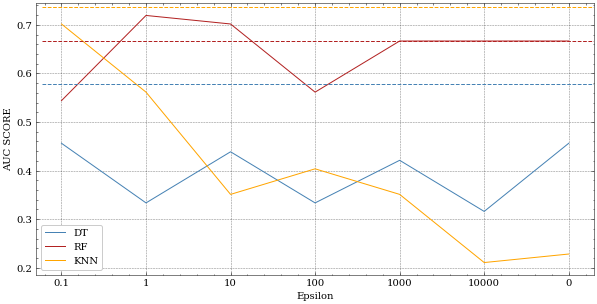

In [218]:
plt.figure(figsize=(10,5))

colors = ['steelblue','firebrick','orange']




plt.plot(dt_score,label='DT',color = colors[0])
plt.plot(rf_score,label='RF',color = colors[1])
plt.plot(knn_score,label='KNN',color = colors[2])

for i, score in enumerate(real_score):
    plt.axhline(score, 0.01, 1.5, color = colors[i], linestyle='--', linewidth=1)

plt.xticks(np.arange(0, 7, 1), labels=['0.1', '1', '10', '100', '1000', '10000','0'])

plt.xlabel('Epsilon')
plt.ylabel('AUC SCORE')
#plt.plot(mlp_score,label='MLP')
plt.legend()

In [97]:
syn = pd.read_csv(path+f'/Synthetic_data_epsilon10000_50.csv')
syn = syn.drop(['Unnamed: 0','OVR_SURV'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(syn.drop('DEAD',axis=1), syn['DEAD'], test_size = 0.2, stratify=syn['DEAD'])
syn_valid = pd.concat([X_test,y_test],axis=1)
syn_train = pd.concat([X_train,y_train],axis=1)

dt_model_tsts = get_best_model(syn_train,syn_valid,'dt')
rf_model_tsts = get_best_model(syn_train,syn_valid,'rf')


0.9450286938136687 DecisionTreeClassifier(max_depth=10, min_samples_split=3)
0.9700693696926206 RandomForestClassifier(max_depth=10, n_jobs=-1)


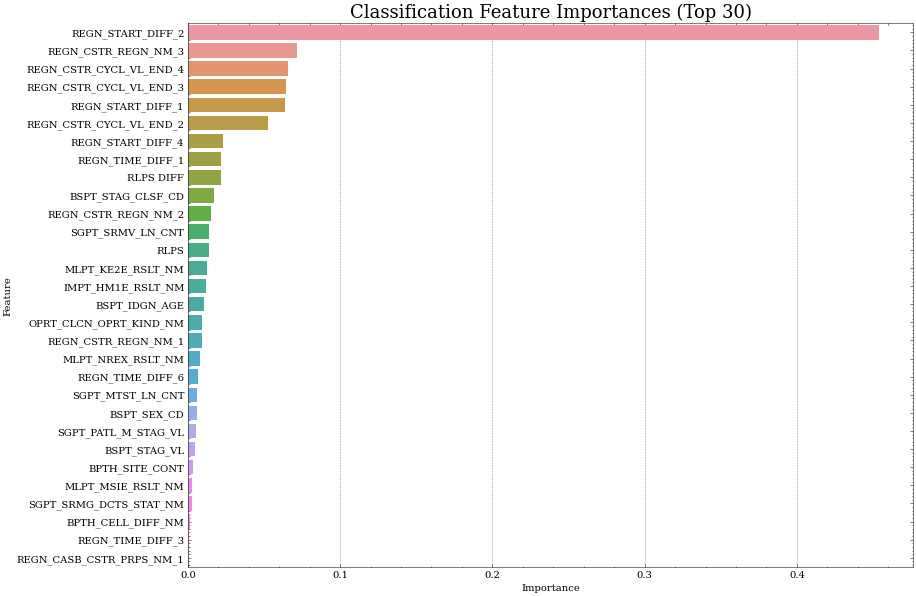

In [96]:
get_feature_importances(dt_model_tsts,test_x.columns)

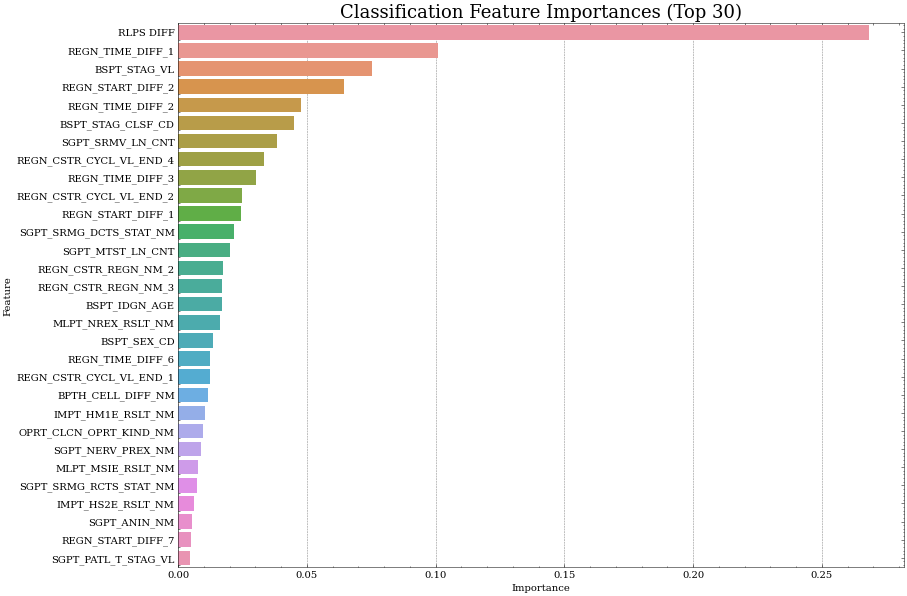

In [98]:
get_feature_importances(dt_model_tsts,test_x.columns)